# Training a voice activity detection pipeline from scratch with `pyannote.audio`

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.  
In this tutorial, you will learn how to train and evaluate a VAD pipeline from scratch.

## Install dependencies

This tutorial requires the following packages:
*   pyannote.audio
*   pyannote.database (I have made some fixes for running in Colab)



In [9]:
!pip install git+https://github.com/CeLuigi/pyannote-audio.git &> /dev/null
!pip install git+https://github.com/CeLuigi/pyannote-database.git &> /dev/null

## Data preparation
1. First we download the [AMI corpus](https://groups.inf.ed.ac.uk/ami/corpus/) has already been [setup for use with `pyannote`](https://github.com/pyannote/AMI-diarization-setup/tree/main/pyannote)
2.  he `PYANNOTE_DATABASE_CONFIG` environment variable is set accordingly.

See [`pyannote.database` documentation](https://github.com/pyannote/pyannote-database#pyannote-database) to learn how to prepare your own dataset for training with `pyannote.audio`.

In [1]:
import os

# move diarization folder to datasets/AMI-diarization-setup
if not os.path.exists('./datasets/AMI-diarization-setup'):
    !git clone https://github.com/pyannote/AMI-diarization-setup.git &> /dev/null
    os.rename('AMI-diarization-setup', 'datasets/AMI-diarization-setup')
%cd ./datasets/AMI-diarization-setup/pyannote
%pwd

/Users/mirkomorello/Documents/Università/Magistrale/ICT/datasets/AMI-diarization-setup/pyannote


/Users/mirkomorello/Documents/Università/Magistrale/ICT/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/mirkomorello/Documents/Università/Magistrale/ICT/datasets/AMI-diarization-setup/pyannote'

In [2]:
# check if the dataset is already downloaded
if not os.path.exists('./amicorpus'):
    !sed -i 's/#!\/bin\/sh/#!\/bin\/bash/' download_ami_mini.sh
    !chmod +x download_ami_mini.sh
    !./download_ami_mini.sh # We download this reduced version of the dataset due to time constraints
    #!./download_ami.sh  # For those who want to dabble at home this is the full version of the dataset

In [3]:
!export PYANNOTE_DATABASE_CONFIG='./datasets/AMI-diarization-setup/pyannote/database.yml'

In [4]:
import os
from pyannote.database import get_protocol, FileFinder

# Ensure the environment variable is set correctly
os.environ['PYANNOTE_DATABASE_CONFIG'] = './datasets/AMI-diarization-setup/pyannote/database.yml'

preprocessors = {"audio": FileFinder()}
ami = get_protocol('AMI.SpeakerDiarization.mini',
                   preprocessors=preprocessors)

'AMI-SDM.SpeakerDiarization.only_words' found in /Users/mirkomorello/Documents/Università/Magistrale/ICT/datasets/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in /Users/mirkomorello/Documents/Università/Magistrale/ICT/datasets/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in /Users/mirkomorello/Documents/Università/Magistrale/ICT/datasets/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in /Users/mirkomorello/Documents/Università/Magistrale/ICT/datasets/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'fil

`pyannote.database` *protocols* usually define
* a training set: `for training_file in protocol.train(): ...`,
* a validation set: `for validation_file in protocol.development(): ...`
* an evaluation set `for evaluation_file in protocol.test(): ...`

Let's listen to one minute of the first training file...

/Users/mirkomorello/Documents/Università/Magistrale/ICT/lib/python3.11/site-packages/pyannote/database/util.py:178: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(
/Users/mirkomorello/Documents/Università/Magistrale/ICT/lib/python3.11/site-packages/pyannote/database/util.py:284: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_uem, names=names, dtype=dtype, delim_whitespace=True)
Matplotlib is building the font cache; this may take a moment.


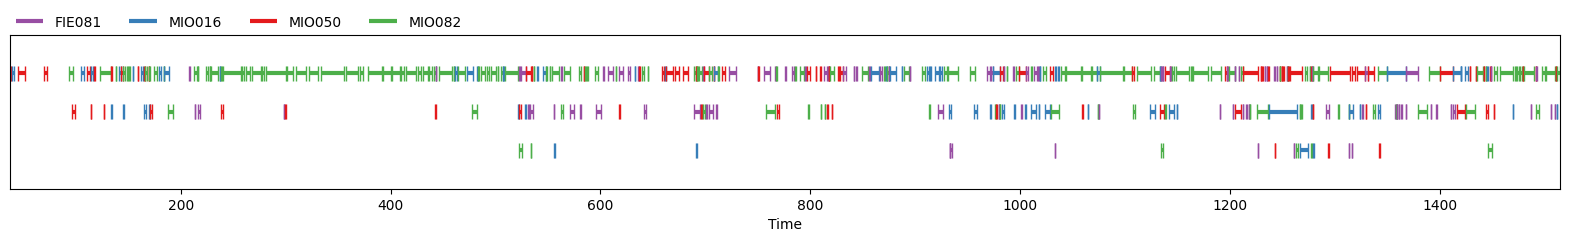

In [6]:
first_training_file = next(ami.train())
reference = first_training_file["annotation"]
reference

In [13]:
# import torch audio
import torchaudio
# import listen to listen to the audio
from IPython.display import Audio
# import pyannote audio
import torchaudio
from IPython.display import Audio
from pyannote.audio.core.io import Audio
from pyannote.audio.core.io import Audio
from pyannote.audio.core.io import Audio
# import pyannote audio pipeline


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from pyannote.audio.utils.preview import listen
from pyannote.core import Segment
one_minute = Segment(240, 300)
listen(first_training_file, one_minute)


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'numpy.char'

... and visualize the manual annotation:

In [12]:
from pyannote.core import notebook
notebook.crop = one_minute

NameError: name 'one_minute' is not defined

## Training

We initialize a VAD *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [ ]:
from pyannote.audio.tasks import VoiceActivityDetection
vad = VoiceActivityDetection(ami, duration=2., batch_size=128)

We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).


![](https://d3i71xaburhd42.cloudfront.net/2540f32662aad59f66d0d9b00b9ad4721a9e522a/2-Figure1-1.png)


In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.
The model is also provided with the task (`task=vad`) for which it is being trained:

In [ ]:
from pyannote.audio.models.segmentation import PyanNet
model = PyanNet(sincnet={'stride': 10}, task=vad).cuda()

Now that everything is ready, let's train with `pytorch-ligthning`!

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=2)
trainer.fit(model)

For the purpose of this tutorial, the model is trained for only 2 epochs. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

## Inference

Once trained, the model can be applied to a test file:

In [ ]:
test_file = next(ami.test())
# here we use a test file provided by the protocol, but it could be any audio file
# e.g. test_file = "/path/to/test.wav".

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

In [ ]:
from pyannote.audio import Inference
inference = Inference(model)
vad_probability = inference(test_file)

In [ ]:
vad_probability

Perfect voice activity detection output should look like that:

In [ ]:
expected_output = test_file["annotation"].get_timeline().support()
expected_output

## Pipeline

Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.6`: mark region as `active` when probability goes above 0.6
- `offset=0.4`: switch back to `inactive` when probability goes below 0.4
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [ ]:
from pyannote.audio.pipelines import VoiceActivityDetection as VoiceActivityDetectionPipeline
pipeline = VoiceActivityDetectionPipeline(segmentation=model)
initial_params = {"onset": 0.6, "offset": 0.4,
                  "min_duration_on": 0.0, "min_duration_off": 0.0}
pipeline.instantiate(initial_params)

Here we go:

In [ ]:
pipeline(test_file).get_timeline()

In [ ]:
expected_output

Looks decent! Let's perform a proper evaluation by computing the [detection error rate](https://pyannote.github.io/pyannote-metrics/reference.html#detection) over the whole AMI test set:


$$detection\_error\_rate = \frac{false\_alarm + missed\_detection}{total}$$


where $false\_alarm$ is the duration of non-speech incorrectly classified as speech, $missed\_detection$ is the duration of speech incorrectly classified as non-speech, and $total$ is the total duration of speech in the reference

In [ ]:
from pyannote.metrics.detection import DetectionErrorRate
metric = DetectionErrorRate()

for file in ami.test():

    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],     # this is the reference annotation
        speech,                 # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated

# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

## Optimizing pipeline hyper-parameters

While good enough, the hyper-parameters that we chose manually, we can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [ ]:
pipeline.freeze({'min_duration_on': 0.0, 'min_duration_off': 0.0})

In [ ]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(ami.development()),
               warm_start=initial_params,
               n_iterations=20,
               show_progress=False)

optimized_params = optimizer.best_params

There you go: better hyper-parameters that (should) lead to better results!

In [ ]:
print(optimized_params)

Let's evaluate the voice activity detection pipeline with this new set of hyper-parameters:

In [ ]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = DetectionErrorRate()

for file in ami.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])

detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')

*🎉* Yeay! 2% relativement improvement simply by tuning the thresholds.